https://www.astroml.org/astroML-notebooks/chapter6/astroml_chapter6_Gaussian_Mixture_Models.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture

from astroML.datasets import fetch_sdss_sspp
from astroML.plotting.tools import draw_ellipse

In [2]:
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

In [3]:
N = np.arange(2, 14)

def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

best fit converged: True
BIC: n_components =  5


In [4]:
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                          np.meshgrid(0.5 * (FeH_bins[:-1]
                                             + FeH_bins[1:]),
                                      0.5 * (alphFe_bins[:-1]
                                             + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

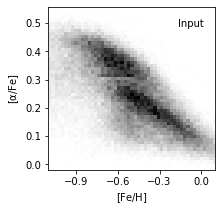

In [5]:
fig = plt.figure(figsize=(3, 3))

# define plot_figure to plot all figures with the same format.
def plot_figure(number, data, text):
    ax = fig.add_subplot(number)
    ax.imshow(data,
              origin='lower', interpolation='nearest', aspect='auto',
              extent=[FeH_bins[0], FeH_bins[-1],
                      alphFe_bins[0], alphFe_bins[-1]],
              cmap=plt.cm.binary)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
    ax.set_xlabel(r'$\rm [Fe/H]$')
    ax.set_xlim(-1.101, 0.101)
    ax.text(0.93, 0.93, text,
            va='top', ha='right', transform=ax.transAxes)
    ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
    return ax

ax = plot_figure(111, H.T, "Input")
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
plt.show()

Text(0.5, 0, 'N components')

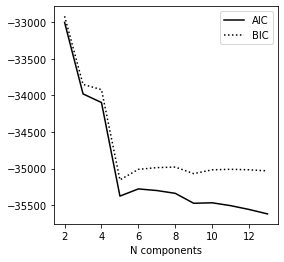

In [9]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
#plt.setp(ax.get_yticklabels(), fontsize=7)

Text(0, 0.5, '$\\rm [\\alpha/Fe]$')

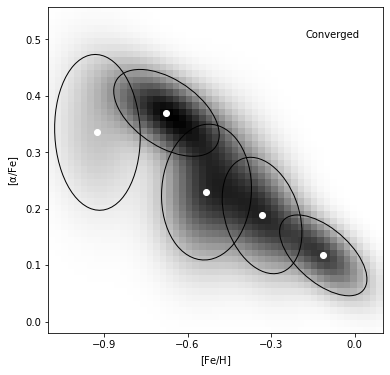

In [8]:
fig = plt.figure(figsize=(6,6))

ax = plot_figure(111, np.exp(log_dens), "Converged")

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.set_ylabel(r'$\rm [\alpha/Fe]$')

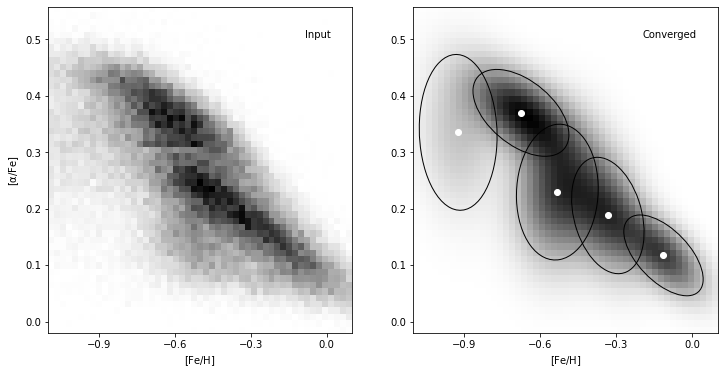

In [11]:
fig = plt.figure(figsize=(12, 6))

# plot density
ax1 = plot_figure(121, H.T, "Input")
ax1.set_ylabel(r'$\rm [\alpha/Fe]$')

ax2 = plot_figure(122, np.exp(log_dens), "Converged")
ax2.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax2, fc='none', ec='k')

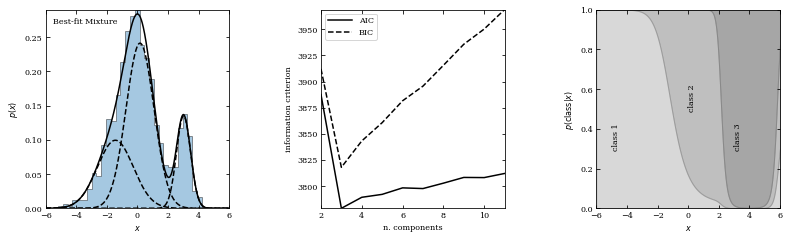

In [14]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Set up the dataset.
#  We'll create our dataset by drawing samples from Gaussians.

random_state = np.random.RandomState(seed=1)

X = np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(2, 12)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

x = np.linspace(-6, 6, 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()